In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re

c:\Users\zhero\anaconda3\envs\DSU\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )
        
        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [3]:
# Prepare your data
products_df = pd.read_csv('groceries_cleaned.csv')
texts = products_df['title'] + ' ' + products_df['combined_description']

In [4]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=50, max_clusters = 200)

In [5]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='combined')

CLUSTERING BY KMEANS
CLUSTERING BY BERT


2025-03-01 12:49:54,559 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-01 12:50:43,314 - BERTopic - Dimensionality - Completed ✓
2025-03-01 12:50:43,317 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-01 12:50:43,622 - BERTopic - Cluster - Completed ✓
2025-03-01 12:50:43,636 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-01 12:50:44,943 - BERTopic - Representation - Completed ✓


CREATING FINAL CLUSTERING COMBINATION


In [6]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [7]:
# Number of total products
products_df.shape[0] 

8600

In [8]:
# Number of clusters
len(cluster_stats)

172

In [9]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 20
Key Terms: foods market, 365, roast, arabica, standards

Cluster Size: 20
Key Terms: tea, the, free, green, teas

Cluster Size: 62
Key Terms: 365, whole, foods, standards, organic

Cluster Size: 98
Key Terms: chocolate, candy bars, chewy, candies, candy

Cluster Size: 157
Key Terms: roast, ground, ground coffee, medium roast, free

Cluster Size: 70
Key Terms: sauce, cheese, pasta, cream, tomato

Cluster Size: 240
Key Terms: chocolate, cream, cookies, vegan, frozen

Cluster Size: 56
Key Terms: tea, blend, spices, tea bags, herbal

Cluster Size: 79
Key Terms: gluten, classic, whole, hot, granola

Cluster Size: 22
Key Terms: turkey, cheese, dressing, kit, olive



In [10]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

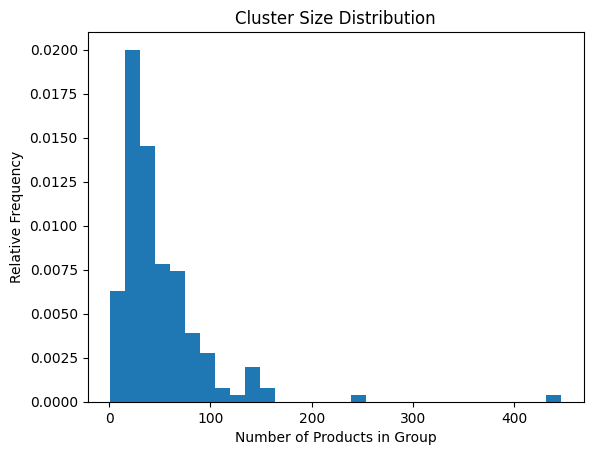

In [11]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [12]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

label
126    446
6      240
21     159
4      157
41     144
Name: count, dtype: int64

In [13]:
# Largest Group Info
cluster_stats[134]

{'size': 11,
 'terms': ['creamy', 'real', 'vinegar', 'oil', 'eggs'],
 'sample_products': ["Lorissa's Kitchen Grass-Fed Beef Jerky Meat Snack Sticks - Keto Friendly, Gluten Free, No Added Nitrites or Nitrates, Original Flavor, 1 oz. Pack of 12 When you need a wholesome and satisfying snack for your family you need Lorissas Kitchen Original Beef Sticks Made with 100 grassfed beef raised without added growth hormones or antibiotics you can trust these savory sweet meat snacks are carefully sourced using only highquality ingredients These perfectly tender Original beef sticks are seasoned with a delicious blend of savory spices then slowsmoked for a complex yet smooth craveable flavor the whole family will love Made with no preservatives added nitrates or nitrites or MSG they are the goto glutenfree and ketofriendly snack for go time you can feel good about feeding your family Packed with 6g of protein per serving this good source of protein premium beef stick fuels and energizes you tackl

In [14]:
products_df.to_csv("labeled_groceries.csv", index=False)